### Yolo11 tests

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os , sys
import json
sys.path.append('..')
from pathlib import Path
cur_path = Path(os.getcwd()).parent
sam2_path = cur_path / 'sam2_octron'
sys.path.append(cur_path.as_posix())
from matplotlib import pyplot as plt
import cmasher as cmr
import numpy as np
import seaborn as sns
sns.set_theme(style='white')
%config InlineBackend.figure_format = 'retina'

In [3]:
# Object organizer
from octron.sam2_octron.object_organizer import load_object_organizer
from octron.sam2_octron.helpers.sam2_zarr import load_image_zarr, create_image_zarr
# #### Importing additional stuff 
# from skimage import measure
# from skimage.draw import polygon2mask

In [4]:
from napari_pyav._reader import FastVideoReader
from octron.yolo_octron.helpers.polygons import get_polygons, draw_polygons   

In [5]:
from ultralytics import YOLO
from ultralytics import settings
settings.update({'sync': False,'hub':False, })

In [6]:
settings.update({'datasets_dir': '','weights_dir':'', 'runs_dir':'OCTRON RUNS'})

In [7]:
# Presaved model (YOLOv11)
path_to_model = Path('/Users/horst/Documents/python/OCTRON/octron/yolo_octron/yolo11l-seg.pt')
# Output data from annotation in OCTRON
path_to_json_organizer = Path('/Users/horst/Downloads/octron_project/object_organizer.json')

In [45]:
organization = load_object_organizer(path_to_json_organizer)  
assert organization is not None

label_dict = {}
for entry in organization['entries'].values():
    label_id = int(entry['label_id'] )
    label    = entry['label'] 
    
    if label_id in label_dict:
        assert label_dict[label_id]['label'] == label
    else:
        label_dict[label_id] = {'label':label, 'frames': []}   
    # Find out which frames were annotated
    zarr_path = Path(entry['prediction_layer_metadata']['zarr_path'])
    assert zarr_path.exists()

    num_frames, image_height, image_width = entry['prediction_layer_metadata']['data_shape']
    num_ch = entry['prediction_layer_metadata']['ndim']
    loaded_masks, status = load_image_zarr(zarr_path, 
                                num_frames,
                                image_height, 
                                image_width, 
                                num_ch=None
                                )
    assert status == True
    assert loaded_masks is not None
    annotated_indices = np.where(loaded_masks[:,0,0] >= 0)[0]
    label_dict[label_id]['frames'].extend(annotated_indices) 
    
# Maintain only unique entries in 'frames' lists
for label_id in label_dict:
    _, i = np.unique(label_dict[label_id]['frames'], return_index=True)
    label_dict[label_id]['frames'] = np.array(label_dict[label_id]['frames'])[np.sort(i)]
    print(f'Label {label_dict[label_id]["label"]} has {len(label_dict[label_id]["frames"])} annotated frames')
    

📖 Octron object organizer loaded from /Users/horst/Downloads/octron_project/object_organizer.json
Label wormsy has 228 annotated frames
Label handle has 174 annotated frames


0


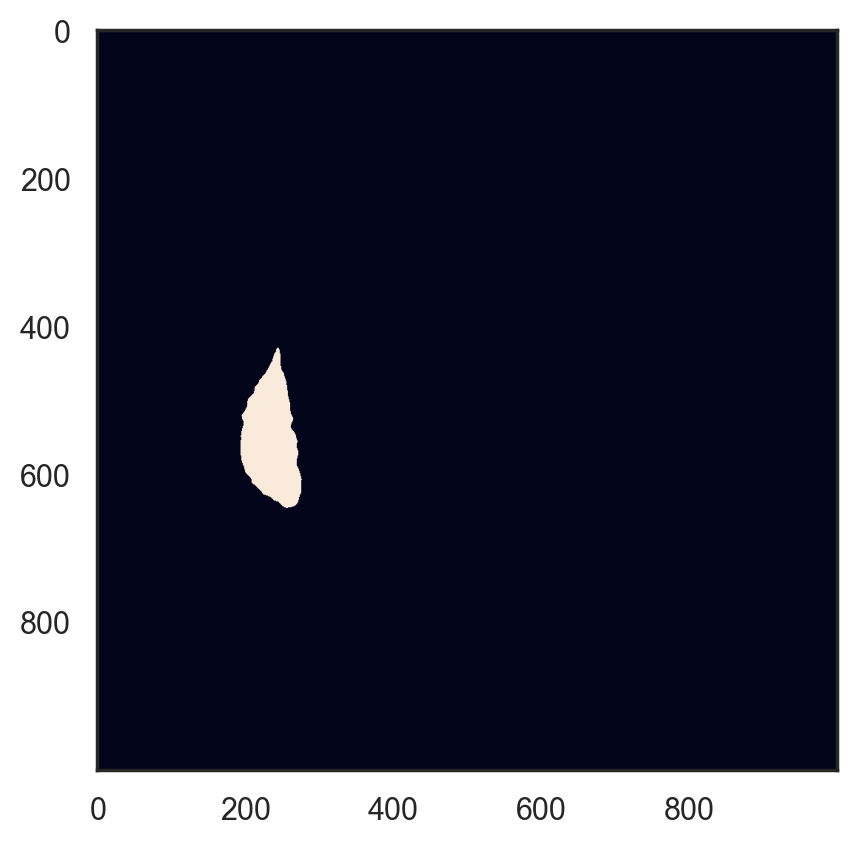

In [11]:
for i in annotated_indices:
    print(i)
    plt.imshow(loaded_masks[i])
    plt.show()  
    break

In [12]:
polygon_points = get_polygons(loaded_masks[0])  
polygon_points.shape

(205, 2)

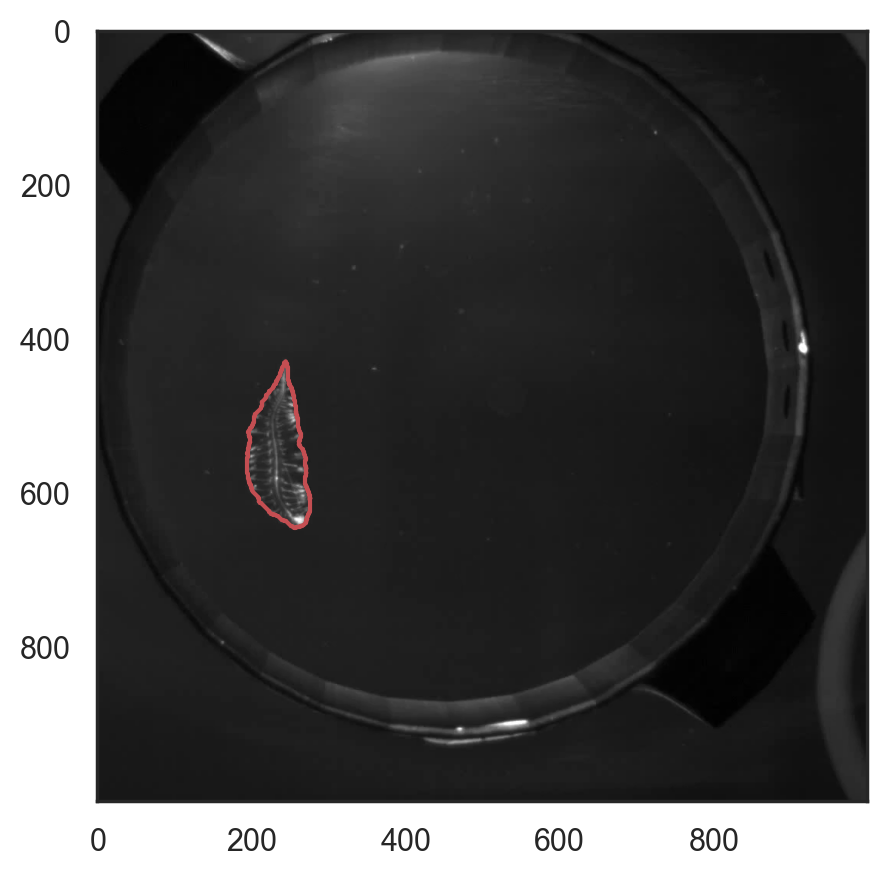

In [13]:
figure = plt.figure(figsize=(5,5))
ax = figure.add_subplot(111)
ax.imshow(video_data[i])

draw_polygons(polygon_points, ax, color='r', lw=1.5)    


In [17]:
# Create some kind of folder structure 
assert zarr_path.parent.exists()
basefolder = zarr_path.parent
if not (zarr_path.parent / 'training_data').exists():
    os.mkdir(zarr_path.parent / 'training_data')
training_folder = basefolder / 'training_data'

In [23]:
#model = YOLO(path_to_model)  # load a pretrained model (recommended for training)


In [ ]:
# # Train/val/test sets as 
# 1) dir: path/to/imgs, 
# 2) file: path/to/imgs.txt, or list: [path/to/imgs1, path/to/imgs2, ..]
# path: ../datasets/coco8-seg # dataset root dir (absolute or relative; if relative, it's relative to default datasets_dir)
# train: images/train # train images (relative to 'path') 4 images
# val: images/val # val images (relative to 'path') 4 images
# test: # test images (optional)
